In [1]:
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git -q
! git clone https://github.com/maussn/GRS34806-project.git -q

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import sys
import os
from pathlib import Path
import random
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from functools import total_ordering
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
        nn.init.xavier_uniform_(layer.weight)


In [3]:
os.chdir(Path('grs34806-deep-learning-project-data'))

# Data loading

In [4]:
def read(seqfile: str, posfile: str) -> tuple[list, list]:
    """Read file with sequences and file with positive cases into lists.

    :param seqfile: file with sequences
    :type seqfile: str
    :param posfile: file with positive cases (annotated with function)
    :type posfile: str
    :return: two lists, first with sequences and second with boolean labels
    :rtype: tuple[list, list]
    """
    idlist = []
    datalist = []
    labellist = []
    with open(seqfile, 'r') as f:
        for line in f.readlines():
            line = line.rstrip().split('\t')
            idlist.append(line[0])
            datalist.append(line[1])
            labellist.append(False)
    with open(posfile, 'r') as f:
        for line in f.readlines():
            id = line.rstrip()
            try:
                i = idlist.index(id)
                labellist[i] = True
            except ValueError:
                continue
    return datalist, labellist


def split_labelled(datalist: list, labellist: list):
    pos_datalist = []
    neg_datalist = []
    for i, label in enumerate(labellist):
        if label:
            pos_datalist.append(datalist[i])
        else:
            neg_datalist.append(datalist[i])
    return pos_datalist, neg_datalist


def remove_sequences(datalist: list, fraction=0.5):
    random.shuffle(datalist)
    i = round(len(datalist) * fraction)
    return datalist[:i]


def remove_sequences_equal(reduced_datalist: list, compared_datalist: list):
    random.shuffle(reduced_datalist)
    random.shuffle(compared_datalist)
    reduced_datalist = reduced_datalist[:len(compared_datalist)]
    if len(compared_datalist) != len(reduced_datalist):
        raise ValueError
    return reduced_datalist


def fuse_sequence_lists(pos_datalist: list, neg_datalist: list):
    pos_labels = [True for _ in pos_datalist]
    neg_labels = [False for _ in neg_datalist]
    datalist = pos_datalist + neg_datalist
    labellist = pos_labels + neg_labels
    return datalist, labellist


def generate_train_test(datalist: list, labellist: list, fraction: float=0.8):
    """Split up dataset in training set and test set

    :param datalist: list with sequences
    :type datalist: list
    :param labellist: list with labels
    :type labellist: list
    :param ratio: fraction to be added to the training set, remainder is added to the test set, defaults to 0.8
    :type ratio: float, optional
    :return: four lists, first two the training data and labels, second two the test data and labels
    :rtype: tuple[list, list, list, list]
    """
    c = list(zip(datalist, labellist))
    random.shuffle(c)
    datalist[:], labellist[:] = zip(*c)
    i = round(len(datalist) * fraction)
    traindatalist = datalist[:i]
    trainlabellist = labellist[:i]
    testdatalist = datalist[i:]
    testlabellist = labellist[i:]
    return traindatalist, trainlabellist,testdatalist,testlabellist


def tokenize(data: list, map2num: dict, non_aa_num: int=20) -> list:
    """Tokenize all sequences in a list

    :param data: list of sequences to tokenize
    :type data: list
    :param map2num: ammino acid -> integer token mapping
    :type map2num: dict
    :param non_aa_num: token for non amino acid characters, defaults to 20
    :type non_aa_num: int, optional
    :return: list of tokenized sequences
    :rtype: list
    """
    seq = []
    for count, i in enumerate(data):
        seq.append([map2num.get(j,non_aa_num) for j in list(i)])
    return seq


def truncate_pad(line: list, num_steps: int, padding_token: int) -> list:
    """Truncate or pad a tokenized sequence

    :param line: tokenized sequence
    :type line: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param padding_token: token to be used for padding
    :type padding_token: int
    :return: truncated/padded sequence
    :rtype: list
    """
    if len(line) > num_steps:
        return line[:num_steps] # Truncate
    return line + [padding_token] * (num_steps - len(line)) # Pad


def build_seq_array(lines: list, num_steps: int, non_aa_num: int=20) -> torch.tensor:
    """Truncate or pad tokenized sequences and convert to tensor

    :param lines: tokenized sequences
    :type lines: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param non_aa_num: token for padding, defaults to 20
    :type non_aa_num: int, optional
    :return: tensor with truncated/padded tokenized sequences
    :rtype: torch.tensor
    """
    return torch.tensor([truncate_pad(l, num_steps, non_aa_num) for l in lines], dtype=torch.long)


def load_array(data_arrays: tuple[torch.tensor, torch.tensor], batch_size: int, is_train: bool=True) -> torch.utils.data.DataLoader:
    """Construct a PyTorch data iterator.

    Taken from d2l package"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)


def load_data(batch_size: int, num_steps: int, dataset: tuple[list, list]) -> torch.utils.data.DataLoader:
    """Tokenize sequence/label dataset and load into dataloader.

    :param batch_size: size of each batch
    :type batch_size: int
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param dataset: first list contains sequences, second labels
    :type dataset: tuple[list, list]
    :return: torch dataloader which gives a tensor of sequences in a batch and a tensor with their labels
    :rtype: torch.utils.data.DataLoader
    """
    mapaa2num = {aa: i for (i, aa) in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
    seq,lab = dataset
    seq = tokenize(seq, mapaa2num)
    seq_array = build_seq_array(seq, num_steps)
    data_arrays = (seq_array, torch.tensor(lab, dtype=torch.long))
    data_iter = load_array(data_arrays, batch_size)
    return data_iter

# Load paired data

In [87]:
batch_size = 10
num_steps = 1000

# Example for one of the simulated datasets
datalist, labellist = read("expr5Tseq_filtGO_100-1000.lis", "GO_3A0055085.annotprot")
# datalist, labellist = read("len200_500_n5000nr4.seq", "len200_500_n5000nr4.pos")

# Remove negatives
pos_datalist, neg_datalist = split_labelled(datalist, labellist)
neg_datalist = remove_sequences(neg_datalist, 0.1)
# neg_datalist = remove_sequences_equal(neg_datalist, pos_datalist)
datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.6)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

print(next(iter(train_iter)))

[tensor([[10, 17,  9,  ..., 20, 20, 20],
        [10,  0,  0,  ..., 20, 20, 20],
        [10,  3,  7,  ..., 20, 20, 20],
        ...,
        [10,  9,  5,  ..., 20, 20, 20],
        [10, 15, 17,  ..., 20, 20, 20],
        [10, 15, 14,  ..., 20, 20, 20]]), tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])]


p = 226
n = 656


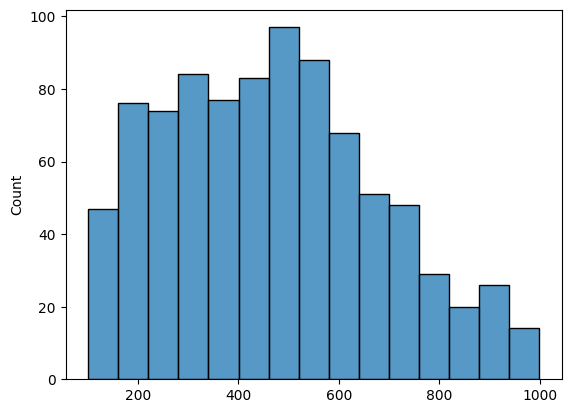

In [88]:
len_list = []
for s in datalist:
    len_list.append(len(s))
sns.histplot(len_list)

p = 0
n = 0
for l in labellist:
    if l:
        p += 1
    else:
        n+=1
print(f'{p = }\n{n = }')

# Train functions binary classifier

In [117]:


class Trainer:
    def __init__(self, model, loss_fn, optimizer, device):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device


    def _train_one_epoch(self, train_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.train(True)
        for i, (inputs, labels) in enumerate(train_iter):

            inputs = inputs.to(self.device)
            self.optimizer.zero_grad()

            outputs = self.model(inputs).to('cpu')

            loss = self.loss_fn(outputs, labels)
            result_loss += loss.item()
            loss.backward()

            self.optimizer.step()

            for j, l in enumerate(labels):
                o = outputs[j].tolist().index(max(outputs[j]))
                l = l.item()
                if o == 1 and l == 1:
                    tpos += 1
                elif o == 1 and l == 0:
                    fpos += 1
                elif o == 0 and l == 0:
                    tneg += 1
                elif o == 0 and l == 1:
                    fneg += 1
                else:
                    raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _test_one_epoch(self, test_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_iter):
                inputs = inputs.to(device)

                outputs = self.model(inputs).to('cpu')

                loss = self.loss_fn(input=outputs, target=labels)
                result_loss += loss.item()
                for j, l in enumerate(labels):
                    o = outputs[j].tolist().index(max(outputs[j]))
                    l = l.item()
                    if o == 1 and l == 1:
                        tpos += 1
                    elif o == 1 and l == 0:
                        fpos += 1
                    elif o == 0 and l == 0:
                        tneg += 1
                    elif o == 0 and l == 1:
                        fneg += 1
                    else:
                        raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def train(self, epochs, train_iter, test_iter):
        for epoch in range(epochs):
            train_acc, train_prec, train_rec, train_f, train_loss = self._train_one_epoch(train_iter)
            test_acc, test_prec, test_rec, test_f, test_loss = self._test_one_epoch(test_iter)
            print(f'{epoch = }\t{train_loss=:.5f}\t{test_loss=:.5f}\t{train_acc=:.5f}\t{test_acc=:.5f}\t{test_prec=:.5f}\t{test_rec=:.5f}\t{test_f=:.5f}')



# Minimal model (does not work)

In [ ]:
class MinimalGOClassifierCNN(nn.Module):
    def __init__(self, input_length: int, vocab_size : int=21,  num_filters: int=32, kernel_size: int=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=vocab_size, out_channels=num_filters, kernel_size=kernel_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.LazyLinear(out_features=2)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.conv_layer(x.transpose(1,2))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        output = F.softmax(x, 1)
        return output

# Berry's model (works, go to for binary classification)

In [114]:
class BerryCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, context_size: int, vocab_size: int = 21,  conv_channels: int = 128, use_bias: bool = False):
        super().__init__()
        assert context_size % 2 == 0, f'Invalid context_size, {context_size} is not an even number'

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=2, bias=use_bias)  # binary classification
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x


In [118]:
model = BerryCNN1D(context_size=num_steps, conv_channels=128)
model.apply(init_weights)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model

BerryCNN1D(
  (embedding): Embedding(21, 21)
  (conv1): Sequential(
    (0): Conv1d(21, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): AdaptiveMaxPool1d(output_size=1)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=2, bias=False)
  )
)

In [119]:
trainer = Trainer(model, loss_fn, optimizer, device)
trainer.train(epochs=50, train_iter=train_iter, test_iter=test_iter)

epoch = 0	train_loss=0.59139	test_loss=0.55797	train_acc=0.73157	test_acc=0.75354	test_prec=0.00000	test_rec=0.00000	test_f=0.00000
epoch = 1	train_loss=0.56660	test_loss=0.56278	train_acc=0.73724	test_acc=0.75354	test_prec=0.00000	test_rec=0.00000	test_f=0.00000
epoch = 2	train_loss=0.56258	test_loss=0.55463	train_acc=0.73724	test_acc=0.75354	test_prec=0.00000	test_rec=0.00000	test_f=0.00000
epoch = 3	train_loss=0.54069	test_loss=0.54407	train_acc=0.74669	test_acc=0.75354	test_prec=0.00000	test_rec=0.00000	test_f=0.00000
epoch = 4	train_loss=0.52345	test_loss=0.54486	train_acc=0.73724	test_acc=0.75354	test_prec=0.00000	test_rec=0.00000	test_f=0.00000
epoch = 5	train_loss=0.51655	test_loss=0.57330	train_acc=0.73913	test_acc=0.79037	test_prec=0.88235	test_rec=0.17241	test_f=0.28846
epoch = 6	train_loss=0.51245	test_loss=0.51653	train_acc=0.78450	test_acc=0.75354	test_prec=0.00000	test_rec=0.00000	test_f=0.00000
epoch = 7	train_loss=0.47873	test_loss=0.53008	train_acc=0.77883	test_acc=0.

# Extra convolutional layer (does not improve)

In [ ]:
class MoreCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, context_size: int, vocab_size: int = 21,  conv_channels: int = 128, use_bias: bool = False):
        super().__init__()
        assert context_size % 2 == 0, f'Invalid context_size, {context_size} is not an even number'

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            # conv block 3
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=2, bias=use_bias)  # binary classification
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.fc(x)

In [ ]:
model = MoreCNN1D(context_size=num_steps, conv_channels=128)
model.apply(init_weights)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model

MoreCNN1D(
  (embedding): Embedding(21, 21)
  (conv1): Sequential(
    (0): Conv1d(21, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): AdaptiveMaxPool1d(output_size=1)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=2, bias=False)
  )
)

In [ ]:
trainer = Trainer(model, loss_fn, optimizer)
trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

epoch = 0	train_loss=0.35404	test_loss=0.33095
epoch = 1	train_loss=0.33558	test_loss=0.32332
epoch = 2	train_loss=0.32925	test_loss=0.32346
epoch = 3	train_loss=0.31973	test_loss=0.31417
epoch = 4	train_loss=0.30916	test_loss=0.32241
epoch = 5	train_loss=0.30079	test_loss=0.30237
epoch = 6	train_loss=0.28817	test_loss=0.29379
epoch = 7	train_loss=0.27623	test_loss=0.28432
epoch = 8	train_loss=0.25552	test_loss=0.27249
epoch = 9	train_loss=0.23447	test_loss=0.29422


# Load data multiple labels

In [27]:
def read_multiple_pos(seqfile: str, posfiles: list[str]) -> tuple[list, list]:
    """Read file with sequences and file with positive cases into lists.

    :param seqfile: file with sequences
    :type seqfile: str
    :param posfiles: files with positive cases (annotated with function)
    :type posfile: str
    :return: two lists, first with sequences and second with integer labels
    :rtype: tuple[list, list]
    """
    idlist = []
    datalist = []
    labellist = []
    with open(seqfile, 'r') as f:
        for line in f.readlines():
            line = line.rstrip().split('\t')
            idlist.append(line[0])
            datalist.append(line[1])
            labellist.append([0 for _ in posfiles])
    for l, posfile in enumerate(posfiles):
        with open(posfile, 'r') as f:
            for line in f.readlines():
                id = line.rstrip()
                try:
                    i = idlist.index(id)
                    # if labellist[i] != 0:
                    #     raise Exception(f'Sequence with multiple labels. {id = }, {labellist[i] = }, {l = }')
                    labellist[i][l] = 1
                except ValueError:
                    continue
    return datalist, labellist


def split_labelled_multiple_pos(datalist: list, labellist: list):
    pos_datalist = []
    pos_labellist = []
    neg_datalist = []
    neg_labellist = []
    for i, labels in enumerate(labellist):
        is_pos = False
        for label in labels:
            if label:
                is_pos = True
        if is_pos:
            pos_datalist.append(datalist[i])
            pos_labellist.append(labels)
        else:
            neg_datalist.append(datalist[i])
            neg_labellist.append(labels)
    return pos_datalist, pos_labellist, neg_datalist, neg_labellist


def zip_n_shuffle(list1: list, list2: list) -> tuple[list, list]:
    assert len(list1) == len(list2)
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    list1, list2 = zip(*combined)
    return list(list1), list(list2)


def remove_sequences_multiple_pos(datalist: list, labellist, fraction=0.5):
    datalist, labellist = zip_n_shuffle(datalist, labellist)
    i = round(len(datalist) * fraction)
    return datalist[:i], labellist[:i]


def remove_sequences_equal_multiple_pos(reduced_datalist: list, reduced_labellist: list, compared_datalist: list):
    reduced_datalist, reduced_labellist = zip_n_shuffle(reduced_datalist, reduced_labellist)
    reduced_datalist = reduced_datalist[:len(compared_datalist)]
    reduced_labellist = reduced_labellist[:len(compared_datalist)]
    if len(compared_datalist) != len(reduced_datalist) or len(compared_datalist) != len(reduced_labellist):
        raise ValueError
    return reduced_datalist, reduced_labellist


def fuse_sequence_lists_multiple_pos(pos_datalist: list, pos_labellist:list, neg_datalist: list, neg_labellist):
    datalist = pos_datalist + neg_datalist
    labellist = pos_labellist + neg_labellist
    return datalist, labellist


def calculate_pos_weights(labellist: list):
    total_samples = len(labellist)
    label_counts = torch.Tensor(labellist).sum(0)
    pos_weights = (total_samples - label_counts) / (label_counts + 1e-5)
    return pos_weights

# Trainer multiple labels

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TrainerMultipleClasses:
    def __init__(self, model, loss_fn, optimizer, device):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device


    def _train_one_epoch(self, train_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.train(True)
        for i, (inputs, labels) in enumerate(train_iter):
            inputs = inputs.to(device)
            labels = labels

            self.optimizer.zero_grad()

            outputs = self.model(inputs).to('cpu')
            labels = labels.type(torch.float32)

            loss = loss_fn(input=outputs, target=labels)
            result_loss += loss.item()

            loss.backward()

            self.optimizer.step()
            for b, lab in enumerate(labels):
                out = torch.round(torch.sigmoid(outputs[b]))

                for j, o in enumerate(out):
                    # print(f'{o=}\t{l=}')
                    l = lab[j]
                    if o == 1 and l == 1:
                        tpos += 1
                    elif o == 1 and l == 0:
                        fpos += 1
                    elif o == 0 and l == 0:
                        tneg += 1
                    elif o == 0 and l == 1:
                        fneg += 1
                    else:
                        raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
                    # print(f'{tpos=}\t{fpos=}\t{tneg=}\t{fneg=}')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _test_one_epoch(self, test_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_iter):
                inputs = inputs.to(device)
                labels = labels
                outputs = self.model(inputs).to('cpu')
                labels = labels.type(torch.float32)
                loss = loss_fn(input=outputs, target=labels)
                result_loss += loss.item()
                for b, lab in enumerate(labels):
                    out = torch.round(torch.sigmoid(outputs[b]))
                    for j, o in enumerate(out):
                        l = lab[j]
                        if o == 1 and l == 1:
                            tpos += 1
                        elif o == 1 and l == 0:
                            fpos += 1
                        elif o == 0 and l == 0:
                            tneg += 1
                        elif o == 0 and l == 1:
                            fneg += 1
                        else:
                            raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
        # print(f'{tpos=}\t{fpos=}\t{tneg=}\t{fneg=}')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def train(self, epochs, train_iter, test_iter):
        for epoch in range(epochs):
            train_acc, train_prec, train_rec, train_f, train_loss = self._train_one_epoch(train_iter)
            test_acc, test_prec, test_rec, test_f, test_loss = self._test_one_epoch(test_iter)
            print(f'{epoch = }\t{train_loss=:.5f}\t{test_loss=:.5f}\t{train_acc=:.5f}\t{test_acc=:.5f}\t{test_prec=:.5f}\t{test_rec=:.5f}\t{test_f=:.5f}')

# Model multiple labels

In [21]:
class MultiClassifierCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, num_classes: int, context_size: int, vocab_size: int = 21,  conv_channels: int = 128, use_bias: bool = False):
        super().__init__()
        assert context_size % 2 == 0, f'Invalid context_size, {context_size} is not an even number'

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.MaxPool1d(1),
            nn.Dropout(0)
        )
        self.conv3 = nn.Sequential(
            # conv block 3
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc1 = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=64, bias=use_bias),
            nn.ReLU(),
            nn.Dropout(0)
        )
        self.fc2 = nn.Sequential(
            # flatten + classification head
            nn.LazyLinear(out_features=num_classes, bias=use_bias)
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        return self.fc2(x)


# Load GO data multiple labels

In [22]:
annot_files = [
    "GO_3A0005576.annotprot",
    "GO_3A0005739.annotprot",
    "GO_3A0007165.annotprot",
    "GO_3A0043066.annotprot",
    "GO_3A0055085.annotprot"
]

batch_size = 10
num_steps = 1000

dl, ll = read_multiple_pos("expr5Tseq_filtGO_100-1000.lis", annot_files)

p_dl, p_ll, n_dl, n_ll = split_labelled_multiple_pos(dl, ll)
n_dl, n_ll = remove_sequences_multiple_pos(n_dl, n_ll, 0.1)
dl, ll = fuse_sequence_lists_multiple_pos(p_dl, p_ll, n_dl, n_ll)

train_dl, train_ll, test_dl, test_ll = generate_train_test(dl, ll, 0.6)
train_ds = [train_dl, train_ll]
test_ds = [test_dl, test_ll]

traindataloader = load_data(batch_size, num_steps, train_ds)
testdataloader = load_data(batch_size, num_steps, test_ds)

pos_weights = calculate_pos_weights(train_ll)

print(next(iter(traindataloader)))

[tensor([[10,  0,  0,  ..., 20, 20, 20],
        [10, 19, 14,  ..., 20, 20, 20],
        [10,  7, 15,  ..., 20, 20, 20],
        ...,
        [10,  0, 13,  ..., 20, 20, 20],
        [10, 14,  7,  ..., 20, 20, 20],
        [10, 15,  5,  ..., 20, 20, 20]]), tensor([[0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])]


p = 1454
n = 533


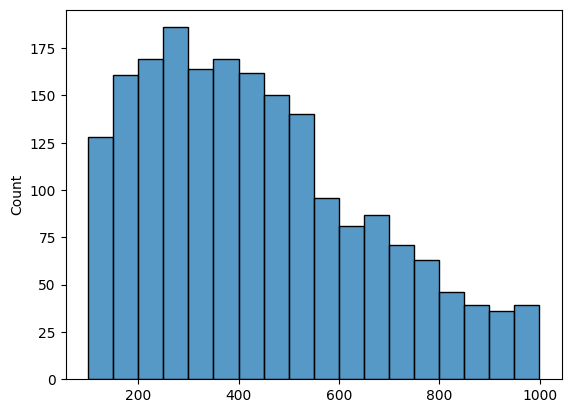

In [18]:
len_list = []
for s in dl:
    len_list.append(len(s))
sns.histplot(len_list)

p = 0
n = 0
for labels in ll:
    found_pos = False
    for l in labels:
        if l:
            p += 1
            found_pos = True
            break
    if not found_pos:
        n+=1
print(f'{p = }\n{n = }')

# Train model multiple labels

In [30]:
model = MultiClassifierCNN1D(num_classes=5, context_size=num_steps, conv_channels=256, use_bias=True)
model.apply(init_weights)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
model

MultiClassifierCNN1D(
  (embedding): Embedding(21, 21)
  (conv1): Sequential(
    (0): Conv1d(21, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveMaxPool1d(output_size=1)
  )
  (fc1): Sequential(
    (0): Flatten(start_di

In [31]:
trainer = TrainerMultipleClasses(model, loss_fn, optimizer, device)
trainer.train(epochs=50, train_iter=traindataloader, test_iter=testdataloader)

epoch = 0	train_loss=1.18734	test_loss=1.18547	train_acc=0.57081	test_acc=0.55270	test_prec=0.14859	test_rec=0.36073	test_f=0.21048
epoch = 1	train_loss=1.16334	test_loss=1.18451	train_acc=0.47315	test_acc=0.45509	test_prec=0.18365	test_rec=0.66667	test_f=0.28797
epoch = 2	train_loss=1.16443	test_loss=1.18143	train_acc=0.50872	test_acc=0.45509	test_prec=0.18365	test_rec=0.66667	test_f=0.28797
epoch = 3	train_loss=1.16709	test_loss=1.18601	train_acc=0.50268	test_acc=0.45509	test_prec=0.18365	test_rec=0.66667	test_f=0.28797
epoch = 4	train_loss=1.16091	test_loss=1.18219	train_acc=0.58926	test_acc=0.71522	test_prec=0.20201	test_rec=0.24505	test_f=0.22146
epoch = 5	train_loss=1.16220	test_loss=1.18381	train_acc=0.54362	test_acc=0.67220	test_prec=0.09524	test_rec=0.11568	test_f=0.10447
epoch = 6	train_loss=1.16423	test_loss=1.18129	train_acc=0.42248	test_acc=0.67220	test_prec=0.09524	test_rec=0.11568	test_f=0.10447
epoch = 7	train_loss=1.16215	test_loss=1.18300	train_acc=0.57483	test_acc=0.